# Handwritten digits mini project

size normalized to fit in a 20x20 pixel box while preserving their aspect ratio

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from model import ConvNet

### Load image

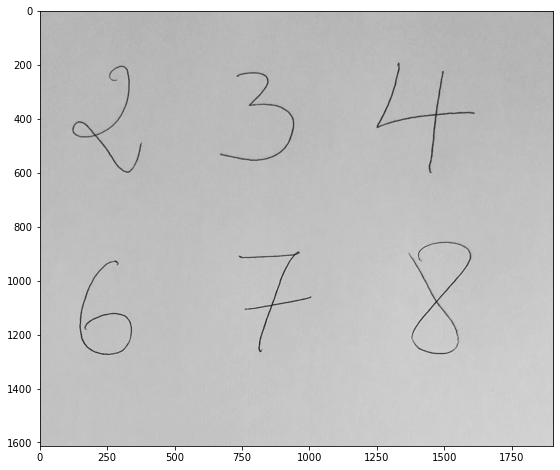

In [2]:
# Import image containing all digits
digits_pth = 'numbers4.jpg'
digits = cv.imread(digits_pth)

gray_digits = cv.cvtColor(digits, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 8))
plt.imshow(gray_digits, cmap='gray');

### Crop each number

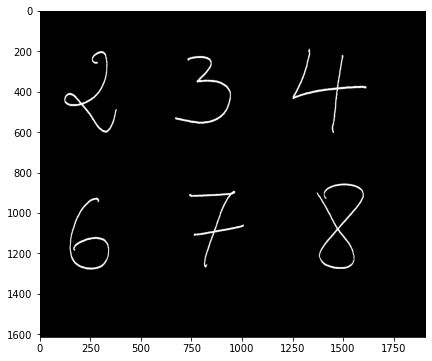

In [4]:
# key factor threshold
_, threshold = cv.threshold(gray_digits,100, 255, cv.THRESH_BINARY_INV)

dilated = cv.dilate(threshold, (3, 3), iterations=5)
# gaussian_blured = cv.GaussianBlur(dilated, (15, 15), 0)
plt.figure(figsize=(8, 6))
plt.imshow(dilated, cmap='gray');

In [5]:
# find contours
contours,_ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print(len(contours)) 
copy_digits = digits.copy()
cv.drawContours(copy_digits, contours, -1, (0, 255, 0), 6)


cv.imshow('', cv.resize(copy_digits, (500, 500)))
cv.waitKey(0)
cv.destroyAllWindows()


6


In [7]:
sorted_contours = sorted(contours, key = cv.contourArea, reverse = True)

copy_digits = digits.copy()
cv.drawContours(copy_digits, sorted_contours[:6], -1, (0, 255, 0), 6)


cv.imshow('', cv.resize(copy_digits, (500, 500)))
cv.waitKey(0)
cv.destroyAllWindows()


In [18]:
# bounding rectangles

final_contours = sorted_contours[:6]
x, y, w, h = cv.boundingRect(final_contours[1])
offset = 70
x = x - offset
y = y - offset
w = w + 2*offset
h = w + 2*offset
copy_digits = digits.copy()
cv.rectangle(copy_digits, (x, y), (x+w, y+h), (0, 255, 0), 10)

cv.imshow('', cv.resize(copy_digits, (500, 500)))
cv.waitKey(0)
cv.destroyAllWindows()

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


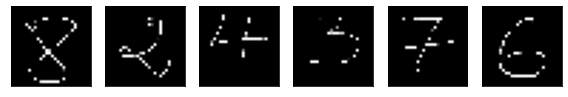

In [46]:
# crop digits
cropped_digits = []
for idx in range(len(final_contours)):
    x, y, w, h = cv.boundingRect(final_contours[idx])
    offset = 70
    x = x - offset
    y = y - offset
    w = w + 2*offset
    h = w + 2*offset

    resized_digit = cv.resize(dilated[y:y+h, x:x+w], (28, 28), interpolation = cv.INTER_CUBIC)
    cropped_digits.append(resized_digit)



plt.figure(figsize=(8, 8))
for idx, digit in enumerate(cropped_digits):
    
    print(digit.shape)
    plt.subplot(1, 6, idx+1)
    plt.imshow(digit, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


In [45]:
# Prediction
# Load model and setup transformation pipeline
convnet = ConvNet()
convnet.load_state_dict(torch.load('model.pth'))

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])



convnet.eval()
with torch.no_grad():
    trsf_digit = transform(cropped_digits[0]).unsqueeze(0)
    logsoft = convnet(trsf_digit)
    print(torch.argmax(logsoft, 1))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9216 and 3136x128)

In [ ]:
# one = all_digits[250:900, 250: 750]
# two = all_digits[250:900, 800: 1350]
# three = all_digits[250:900, 1350: 1950]
# four = all_digits[250:900, 2000:2500]
# five = all_digits[1000:1600, 250:750]
# six =  all_digits[1000:1600, 800: 1300]
# seven = all_digits[1000:1600, 1400: 1950]
# eight = all_digits[1000:1600, 2000: 2550]
# nine = all_digits[1750:2400, 200:700]
# zero = all_digits[1750: 2400, 750: 1350]


# digits = [zero, one, two, three, four, five, six, seven, eight, nine]
# plt.figure(figsize=(8, 8))
# for idx, digit in enumerate(digits):
    
#     plt.subplot(2, 5, idx+1)
#     plt.imshow(digit, cmap='gray')
#     plt.xticks([])
#     plt.yticks([])

# plt.tight_layout()
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()

### Preprocess

In [ ]:
def preprocess(img, n_iterations, kernel):
    """Given an image, applies Otsu thresholding, dilation and finally resizing to 28x28 dimensions

    Args:
        img (ndarray): Image (1 channel) on which on to apply transformations
        n_iterations (int): Number of iterations in dilation step
        kernel (odd int): kernel size in dilation step

    Returns:
        ndarray: a 28X28 image(1 channel)
    """
    _, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    img = cv.dilate(img, (kernel, kernel), iterations=n_iterations)

    return cv.resize(img, (28, 28))
    
    

In [ ]:
preprocessed_imgs = [preprocess(img, 50, 3) for img in digits]
plt.figure(figsize=(8, 8))
for idx, digit in enumerate(preprocessed_imgs):
    
    plt.subplot(2, 5, idx+1)
    plt.imshow(digit, cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


In [ ]:
# Save preprocessed images
for idx, img in enumerate(preprocessed_imgs):
    cv.imwrite(f'images/digits/{str(idx)}.png', img)
    

### Predictions

In [ ]:
# Load model and setup transformation pipeline
convnet = ConvNet()
convnet.load_state_dict(torch.load('model.pth'))

transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5), (0.5))
                                ])

In [ ]:
# Prediction (one at a time)
root_dir = 'images/digits/'
img_file = '9.png'
digit = cv.imread(root_dir + img_file, cv.IMREAD_GRAYSCALE)

convnet.eval()
with torch.no_grad():
    trsf_digit = transform(digit).unsqueeze(0)
    logsoft = convnet(trsf_digit)
    print(torch.argmax(logsoft, 1))

In [ ]:
# Predict all digits

# To visualize predictions
def view_classify(img, ps, pred):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap = 'Greys_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title(f'Prediction: {pred}')
    ax2.set_xlim(0, 1.1)

In [ ]:

for file in os.listdir(root_dir):
    digit = cv.imread(root_dir + file, cv.IMREAD_GRAYSCALE)
    trsf_digit = transform(digit).unsqueeze(0)
    
    convnet.eval()
    with torch.no_grad():
        logsoft = convnet(trsf_digit)

    ps = torch.exp(logsoft)
    pred = torch.argmax(ps, 1).item()
    view_classify(trsf_digit, ps, pred)
    plt.show()
    time.sleep(3)
    clear_output(wait=True)